# CNN-Pretraining: Self-Supervised Learning with Autoencoder

Encoder-Decoder structure, 

input = output, 

l2-loss between output and input, 

decouple decoder, 

save encoder, 

load on RL-model and freeze 


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import numba as nb
import skimage as io
import sklearn as sk
import pandas as pd
import os

from src.Map.Map import load_map
from src.model import Autoencoder, Autoencoder_flex
from src.utils import *

from tensorflow.keras.datasets import mnist
from sklearn.feature_extraction import image
from sklearn.datasets import load_sample_image

2.4.1


![autoencoder](../../res/autoencoder.png)

![autoencoder_pretrained](../../res/pretrained.png)

/home/fede/devel/MA/uavSim/CNN_Pretrain/src/utils.py:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images / float(cols)), n + 1)


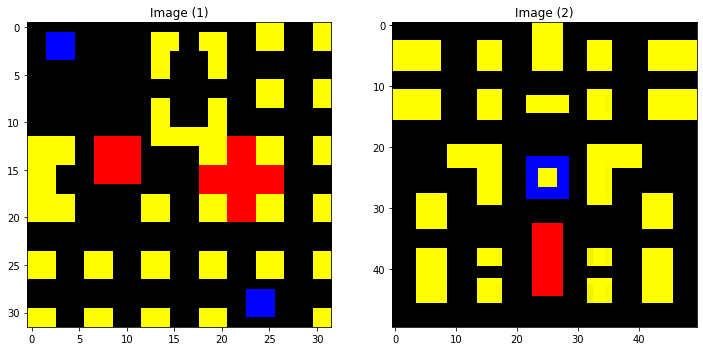

In [2]:
map_paths = ["res/manhattan32.png",
            "res/urban50.png"]

map_in = total_map = load_map(map_paths[1])
print(map_in)


img = [mpimg.imread(map_paths[0]),mpimg.imread(map_paths[1])]
  
# Output Images
# plt.imshow(img[0])
# plt.imshow(img[1])

show_images(img)

# draw_map(map_path)

Patches shape: (1412, 17, 17, 4)
Patches shape: (1412, 17, 17, 4)


/home/fede/devel/MA/uavSim/CNN_Pretrain/src/utils.py:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images / float(cols)), n + 1)


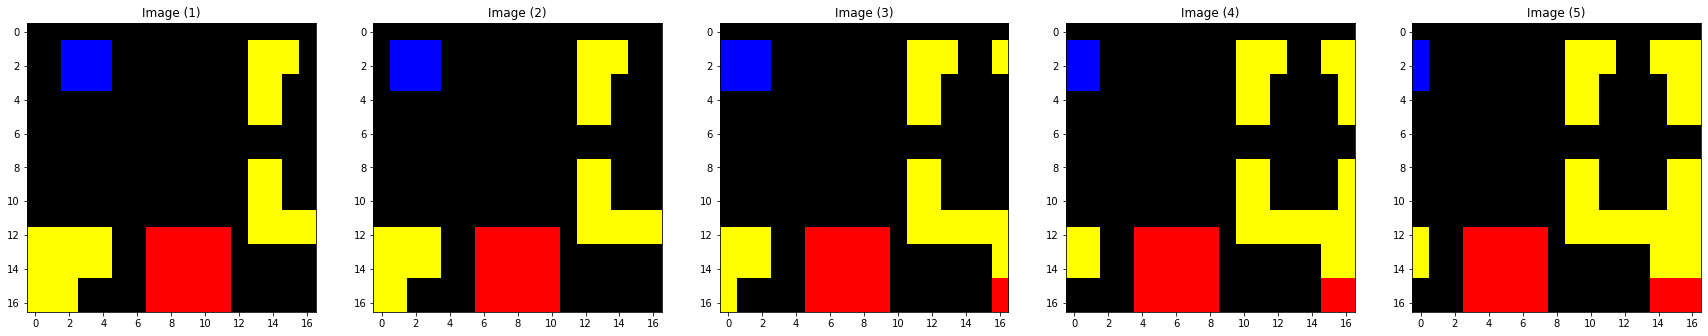

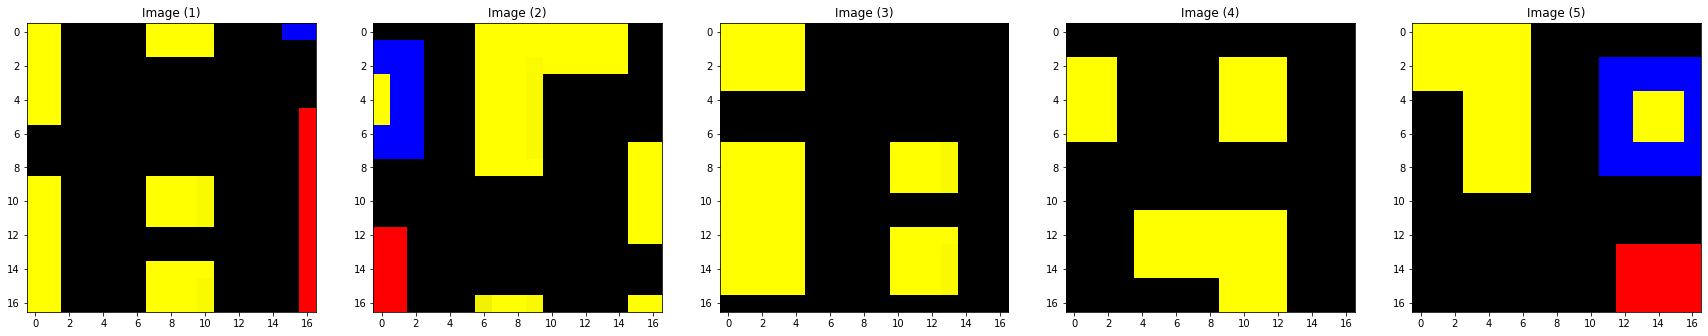

Training samples:(1129, 17, 17, 4)
Test samples:(283, 17, 17, 4)
(17, 17, 4)


In [3]:
"""
Prepare Data
"""

patches = np.concatenate((image.extract_patches_2d(img[0], (17, 17)),
                          image.extract_patches_2d(img[1], (17, 17))),
                         axis=0)

print('Patches shape: {}'.format(patches.shape))

axis_array = np.arange(len(patches[0]))

shuffled_patches = sk.utils.shuffle(patches)

print('Patches shape: {}'.format(patches.shape))

n = int(len(patches)*0.8)


show_images(patches[:5])
show_images(shuffled_patches[:5])

X_train = shuffled_patches[:n]
X_test = shuffled_patches[-(len(patches)-n):]

print("Training samples:{}".format(X_train.shape))
print("Test samples:{}".format(X_test.shape))
print(X_train[0].shape)

In [5]:
dummy_sample = X_train[0][tf.newaxis, ...]
autoenc = Autoencoder_flex(4, X_train[0].shape)
print(dummy_sample.shape, X_train[0].shape)
autoenc.compile(optimizer='adam', loss='mse')
autoenc.build(dummy_sample.shape)
autoenc.summary()

autoenc.fit(X_train, X_train,
                epochs=1,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))


(1, 17, 17, 4) (17, 17, 4)
Model: "autoencoder_flex_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 5, 5, 16)          3064      
_________________________________________________________________
decoder (Sequential)         (1, 142, 142, 4)          8700      
Total params: 11,764
Trainable params: 11,764
Non-trainable params: 0
_________________________________________________________________


ValueError: in user code:

    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1198 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:10250 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/fede/anaconda3/envs/rlvenv/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 142 and 17 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](autoencoder_flex_1/decoder/conv2d_transpose_1/BiasAdd, IteratorGetNext:1)' with input shapes: [?,142,142,4], [?,17,17,4].


In [ ]:
(X_train, _), (X_test, _) = mnist.load_data()
print("X_train", X_train.shape)
print("X_test", X_test.shape)

# print(X_train[0])

def pre_process(X):
    X = X.astype('float32') /255.0
    X = X[..., tf.newaxis]
    return X

X_train  =  pre_process(X_train)
X_test  =  pre_process(X_test)

print("X_train", X_train.shape)
print("X_test", X_test.shape)

print(X_train[0].shape)




In [ ]:

num_model = Autoencoder(num_layers=4)
num_model.compile(optimizer='adam', loss='mse')

num_model.fit(X_train, X_train,
                epochs=1,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))


In [ ]:
num_model.encoder.summary()
num_model.decoder.summary()

In [ ]:
enc_imgs = num_model.encoder(X_test).numpy()
print(enc_imgs.shape)

dec_imgs = num_model.decoder(enc_imgs).numpy()
print(dec_imgs.shape)

plot_bw_figs(10, tf.squeeze(enc_imgs[:,:,0]), 
             tf.squeeze(dec_imgs),  
             tf.squeeze(X_test))
print("enc: {} \n org: {}".format(7*7*8, 28*28))
